In [2]:
# Package imports
import glob
import joblib

import textstat
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

In [3]:
# Import API-transcribed stories
api_t = pd.read_csv("transcribed_stories.csv", 
            usecols=[1,2],
            header=0,
            names=["story_id", "transcription"],
            dtype=str)

In [5]:
api_t.head()

,story_id,transcription
0,3132,Page. I 3132 Once there was a little cheatah a...
1,3104,"3106 D she was very, a berenang The pony that ..."
2,3103,3103 Rainbow the Unica unicom named some een P...
3,3117,3117 O gum drop land gumdrop. land is prace We...
4,3102,3102 The secret fifth grade E am Anella I am s...


In [6]:
# Compile human-transcribed stories

root = "../../Transcribed Stories/"

transcriptions = []

for file in glob.glob(root + '**/**/Story*[3000-5999]*'):
    with open((file), 'r') as file:
        story_id = file.name[-4:]
        transcription = file.read().replace('\n', ' ')
        transcriptions.append((story_id, transcription))

In [7]:
# Generate dataframe of transcriptions
cols = ['story_id', 'transcription']
human_t = pd.DataFrame(transcriptions, columns=cols)

In [8]:
def calc_metrics(df):
    """ 
    Cleans transcriptions and adds various metrics as columns.
    """
    # Avoid SettingWithCopy error
    df = df.copy()
    
    
    # Clean potential transcription errors

    # Strip leading or tailing spaces and integers 
    df["transcription"] = df["transcription"].str.strip().str.strip('/-0123456789')
    
    # Ensure all commas and periods are followed by a space
    df["transcription"] = df["transcription"].str.replace(".", ". ").str.replace(",", ", ")
    
    # Remove any instances of multiple spaces
    df["transcription"] = df["transcription"].str.split().str.join(" ")
    
    
    # Add metrics
    
    # Grade level
    df["grade_level"] = df["story_id"].str[0]

    # Length of story
    df["story_length"] = df["transcription"].str.len()
    
    # Average word length
    word_count = (df["transcription"].str.split()).str.len()
    df["avg_word_len"] = df["story_length"] / word_count
    
    # Number of quotation marks
    df["quotes_number"] = df["transcription"].str.count('"')
    
    # Percentage of complex words, based on textstat's automated function
    # Compares to list of 3000 most commonuly used English words
    # Number of words in story that are not on that list are considered "complex"
    # Note: prone to errors, may need to be iterated on to be production-grade
    num_complex_words = df["transcription"].apply(textstat.difficult_words)
    df["percent_complex_words"] = num_complex_words / word_count * 100
    
    return df

In [9]:
# Calculate both API and human transcription metrics
human_metrics = calc_metrics(human_t)
api_metrics = calc_metrics(api_t)

In [10]:
human_metrics.head(1)

,story_id,transcription,grade_level,story_length,avg_word_len,quotes_number,percent_complex_words
0,3101,Once apon a time there was a girl named Mary. ...,3,1675,5.0,3,7.164179


In [11]:
api_metrics.head(1)

,story_id,transcription,grade_level,story_length,avg_word_len,quotes_number,percent_complex_words
0,3132,Page. I 3132 Once there was a little cheatah a...,3,1375,5.092593,6,4.814815


In [12]:
scaler_h = StandardScaler()
scaler_h.fit(human_metrics.iloc[:,3:])

# Uncomment line below to pickle scaler for future use
# joblib.dump(scaler_h, "scaler_h.pkl")

StandardScaler(copy=True, with_mean=True, with_std=True)

In [13]:
scaler_api = StandardScaler()
scaler_api.fit(api_metrics.iloc[:,3:])

# Uncomment line below to pickle scaler for future use
# joblib.dump(scaler_api, "scaler_api.pkl")

StandardScaler(copy=True, with_mean=True, with_std=True)

In [14]:
def scale_row(row, transcription_source):
    """
    Takes one row and scales it according to corresponding scaler.
    
    This function is integrated into the squad_score function
    
    row: full row of dataframe or a list
    transcription_source (str): "api" or "human" based on source of transcription
    """
    if transcription_source == "api":
        scaler = scaler_api
    elif transcription_source == "human":
        scaler = scaler_h
    else:
        raise ValueError("Not a valid transcription source. Valid options: 'api' or 'human'.")
    
    return scaler.transform([row[3:]])

In [15]:
# Test on API transcription sample
test_row = api_metrics.iloc[0]
scale_row(test_row, "api")

array([[ 0.14899145,  0.06957414, -0.29738429, -1.13566709]])

In [16]:
# Test on human transcription sample
test_row = human_metrics.iloc[0]
scale_row(test_row, "human")

array([[ 0.57113154, -0.45854483, -0.89889175, -0.03568899]])

In [17]:
test_row

story_id                                                              3101
transcription            Once apon a time there was a girl named Mary. ...
grade_level                                                              3
story_length                                                          1675
avg_word_len                                                             5
quotes_number                                                            3
percent_complex_words                                              7.16418
Name: 0, dtype: object

In [18]:
def squad_score(row, transcription_source):
    """
    Scales, weights, and adds all metrics for a given transcription.
    
    Scales according to transcription source (see scale_row function).
    Weights according to presribed weights used only for Story Squad analysis.
    
    row: full row of dataframe or a list
    transcription_source (str): "api" or "human" based on source of transcription
    """
    
    # Instantiate weights
    weights = {"grade_level": .5,
              "story_length": 1,
              "avg_word_len": 1,
              "quotes_number": 1,
              "percent_complex_words": 0}
    
    # Scale needed metrics
    scaled = scale_row(row, transcription_source)[0]
    
    # Weight values
    gl = weights["grade_level"] * int(row[2])
    sl = weights["story_length"] * scaled[0]
    awl = weights["avg_word_len"] * scaled[1]
    qn = weights["quotes_number"] * scaled[2]
    pcw = weights["quotes_number"] * scaled[3]
    
    # Add all values
    s_score = gl + sl + awl + qn + pcw
    
    return s_score

In [19]:
h_squad_score = human_metrics[["story_id"]].copy()
h_squad_score["squad_score"] = human_metrics.apply(lambda x: squad_score(x, "human"), axis=1)

ValueError: invalid literal for int() with base 10: 'e'

In [20]:
api_squad_score = api_metrics[["story_id"]].copy()
api_squad_score["squad_score"] = api_metrics.apply(lambda x: squad_score(x, "api"), axis=1)

In [21]:
api_squad_score.head(1)

,story_id,squad_score
0,3132,0.285514


In [22]:
h_squad_score.describe()

,story_id
count,167
unique,166
top,e 2)
freq,2


In [23]:
api_squad_score.describe()

,squad_score
count,167.000000
mean,2.032934
std,2.858062
min,-5.552245
25%,-0.005359
50%,1.520727
75%,3.851089
max,11.516403


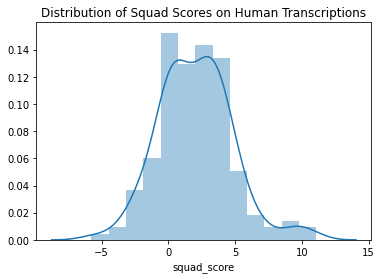

In [152]:
ax = sns.distplot(h_squad_score["squad_score"])
plt.title("Distribution of Squad Scores on Human Transcriptions")
plt.show()

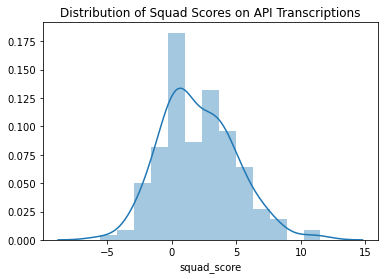

In [24]:
ax = sns.distplot(api_squad_score["squad_score"])
plt.title("Distribution of Squad Scores on API Transcriptions")
plt.show()

In [25]:
# Filter Transcriptions down to 25 hand-ranked stories 
rankings = {"3130": 1,  # key == Story ID, value == rank
             "3112": 2,
             "5109": 3,
             "3118": 4,
             "3122": 5,
             "3108": 6,
             "5108": 7,
             "3121": 8,
             "3101": 9,
             "3128": 10,
             "3106": 11,
             "3126": 12,
             "3129": 13,
             "3105": 14,
             "5104": 15,
             "5101": 16,
             "5103": 17,
             "3125": 18,
             "3111": 19,
             "3119": 20,
             "3110": 21,
             "3117": 22,
             "3127": 23,
             "3131": 24,
             "3120": 25} 



In [201]:
# Subset dataframe for human transcriptions
ranked_stories_h = human_metrics[human_metrics["story_id"].isin(rankings.keys())].reset_index(drop=True)
# Add rankings
ranked_stories_h["ranking"] = ranked_stories_h["story_id"].apply(lambda x: rankings[x])

# Subset dataframe for API transcriptions
ranked_stories_api = api_metrics[api_metrics["story_id"].isin(rankings.keys())].reset_index(drop=True)
# Add rankings
ranked_stories_api["ranking"] = ranked_stories_api["story_id"].apply(lambda x: rankings[x])

In [202]:
# Add Squad Score based on squad_score function
ranked_stories_h["squad_score"] = ranked_stories_h.iloc[:,:-1].apply(lambda x: squad_score(x, "human"), axis=1)
# Add the rank based on the squad score
ranked_stories_h["squad_score_rank"] = ranked_stories_h["squad_score"].rank(ascending=False)

# Repeat for API transcriptions
ranked_stories_api["squad_score"] = ranked_stories_api.iloc[:,:-1].apply(lambda x: squad_score(x, "api"), axis=1)
ranked_stories_api["squad_score_rank"] = ranked_stories_api["squad_score"].rank(ascending=False)


In [204]:
# Look out ranking outcome for human transcriptions
ranked_stories_h[["story_id", "ranking", "squad_score_rank", "squad_score"]]

,story_id,ranking,squad_score_rank,squad_score
0,3117,22,19.0,-1.056141
1,3105,14,10.0,1.040706
2,3129,13,5.0,2.883301
3,3111,19,18.0,-0.476632
4,3118,4,21.0,-1.313509
5,3127,23,23.0,-2.515487
6,3120,25,17.0,-0.048599
7,3121,8,25.0,-4.313544
8,3119,20,20.0,-1.220811
9,3126,12,14.0,0.115512


In [205]:
# Look out ranking outcome for API transcriptions
ranked_stories_api[["story_id", "ranking", "squad_score_rank", "squad_score"]]

,story_id,ranking,squad_score_rank,squad_score
0,3117,22,20.0,-0.524713
1,3105,14,15.0,-0.015317
2,3129,13,2.0,3.518937
3,3111,19,16.0,-0.106132
4,3118,4,19.0,-0.339213
5,3127,23,23.0,-2.627695
6,3120,25,18.0,-0.129501
7,3121,8,24.0,-3.485852
8,3119,20,21.0,-0.627751
9,3126,12,14.0,0.291703


In [222]:
# Calculate MAE & MSE for both 
y_true_h = ranked_stories_h["ranking"]
y_pred_h = ranked_stories_h["squad_score_rank"]
mae_h = mae(y_true_h, y_pred_h)
mse_h = mse(y_true_h, y_pred_h)
print("Human transcriptions:")
print(f"MAE: {mae_h} rankings")
print(f"MSE: {mse_h}")

y_true_api = ranked_stories_api["ranking"]
y_pred_api = ranked_stories_api["squad_score_rank"]
mae_api = mae(y_true_api, y_pred_api)
mse_api = mse(y_true_api, y_pred_api)
print("\nAPI transcriptions:")
print(f"MAE: {mae_api} rankings")
print(f"MSE: {mse_api}")

Human transcriptions:
MAE: 5.44 rankings
MSE: 57.36

API transcriptions:
MAE: 4.48 rankings
MSE: 44.8
